In [8]:
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io, exposure, color, img_as_float, img_as_int, img_as_uint, img_as_ubyte

In [9]:
#Count number of iterates to reach fixed point
def num_iterates(z, func, max_iter = 50, tol = 1e-6, max_radius = 1e10):
    z_new = z
    for i in range(max_iter):
        z_old = z_new
        z_new = func(z_old)
        if abs(z_new - z_old) < tol or abs(z_new) > max_radius:
            return i+1, z_new
    return 0, z_new

#Get matrix of number iterations and fixed points
def get_matrix(func, max_iter=10000, res=100, xlims=None, ylims=None):
    print("Generating...\n")
    if xlims is None and ylims is None:
        out = np.zeros((res, res))
        roots = np.zeros((res, res))
        R = 2*(abs(c))**(1./deg)
        xrange = np.linspace(-R, R, num=res)
        yrange = np.linspace(-R, R, num=res)
    else:
        dx = abs(xlims[0] - xlims[1])
        dy = abs(ylims[0] - ylims[1])
        if dx>dy:
            res_x = res
            res_y = int(res*dy/dx)
        else:
            res_y = res
            res_x = int(res*dx/dy)
        xrange = np.linspace(xlims[0], xlims[1], num=res_x)
        yrange = np.linspace(ylims[0], ylims[1], num=res_y)
        out = np.zeros((res_y, res_x))
        roots = np.zeros((res_y, res_x, 2))
    yrange = np.flip(yrange)

    for x in tqdm_notebook(range(len(xrange))):
        for y in range(len(yrange)):
            num, rt = num_iterates(complex(xrange[x], yrange[y]), func, max_iter=max_iter)
            out[y, x] = num
            roots[y, x, 0] = np.real(rt)
            roots[y, x, 1] = np.imag(rt)
    return out, roots

In [10]:
#Functions

def herman(z):
    t = 0.61517321588
    lam = complex(np.cos(2*np.pi*t), np.sin(2*np.pi*t))
    a = 0.25
    #lam=1
    return lam*z*z*(a*z+1)/(z+a)


def parabolic_basin(z):
    return z + z**5

def blask(z):
    a = complex(2.05133, 0.490272)
    lam=1
    a = complex(0,2.1)

    return z**3*(z-a)/(1-np.conj(a)*z)

def newton(z):
    return z-rat_like(z)/der_rat_like(z)
    

In [11]:
def cubic_intro(z):
    a, b = -1j, np.exp(2*np.pi*1j*0.08)
    c = -np.conj(b)
    return (z-a)*(z-b)*(z-c)

def der_cubic_intro(z):
    a, b = -1j, np.exp(2*np.pi*1j*0.08)
    c = -np.conj(b)
    return (z-a)*(z-b)+(z-a)*(z-c)+(z-b)*(z-c)

def rat_like(z):
    a = complex(0.909382,0.416083)
    return z*(z-1)*(z-a)

def der_rat_like(z):
    a = complex(0.909382,0.416083)
    return z*(z-1)+z*(z-a)+(z-1)*(z-a)
    
def p7(z):
    a = [complex(1,0),complex(-1,0),complex(1,0.3),complex(0.3, 1.1),complex(-0.8, -1.2),complex(0.5, -0.5),complex(-0.2, -0.9)]
    out = 1
    for rt in a:
        out *= (z-rt)
    return out

def dp7(z):
    a = [complex(1,0),complex(-1,0),complex(1,0.3),complex(0.3, 1.1),complex(-0.8, -1.2),complex(0.5, -0.5),complex(-0.2, -0.9)]
    out = 0
    for rt in a:
        out1 = 1
        for rt2 in a:
            out1 *= (z-rt2)
        out += out1/(z-rt)
    return out

In [12]:
#Discretize fixed points to separate by color
def discretize_converging_points(points, mat_iter, tol = 1e-1, max_radius = 1e3):
    print("Discretizing...\n")
    out = np.zeros((points.shape[0], points.shape[1]))
    unique = []
    for i in tqdm_notebook(range(points.shape[0])):
        for j in range(points.shape[1]):
            if mat_iter[i, j] == 0:
                continue
            z = complex(points[i, j, 0], points[i, j, 1])
            found = False
            if abs(z) > max_radius:
                for k in range(len(unique)):
                    if abs(complex(unique[k][0], unique[k][1])) > max_radius:
                        out[i, j] = k
                        found = True
                        break
                if not found:
                    unique.append([points[i, j, 0], points[i, j, 1]])
                    out[i, j] = len(unique) - 1
            else:
                for k in range(len(unique)):
                    if abs(z - complex(unique[k][0], unique[k][1])) < tol:
                        out[i, j] = k
                        found = True
                        break
                if not found:
                    unique.append([points[i, j, 0], points[i, j, 1]])
                    out[i, j] = len(unique) - 1
    print('Number of unique fixed points: {}'.format(len(unique)))
    for k in unique:
        print("({},{})".format(np.round(k[0], decimals=4), np.round(k[1], decimals=4)))
    return np.array(out, dtype='int')

#color pixels
def color_pixel(value, max_val, color):
    if value == 0:
        return [0,0,0]
    return linear_extrapolation_steep(value, 1, max_val, color, np.array([1, 1, 1]))
     
def linear_extrapolation(x, x0, x1, y0, y1):
    return ((y1-y0)/(x1-x0))*(x-x0) + y0

def linear_extrapolation_steep(x, x0, x1, y0, y1):
    a = 0.5
    b = 1-a
    if x < x0+a*(x1-x0):#steep
        return ((b*(y1-y0))/(a*(x1-x0)))*(x-x0) + y0      
    return ((y1 - y0 - b*(y1 - y0))/(x1-x0 - a*(x1-x0)))*(x-x0 - a*(x1-x0)) + y0 + b*(y1-y0)

def log_extrapolation(x, x0, x1, y0, y1):
    return y0 + (y1-y0)/np.log(x1-x0+1)*np.log(x+1-x0)

#Color pixels by fixed point and num iterations
def coloured_newton(mat_iter, conv_points, colors=None):
    roots = discretize_converging_points(conv_points, mat_iter)
    #colors
    if colors is None:
        colors = [[255,0,0], [255,91,0], [255,198,0], [198,255,0], [91,255,0], [0,255,0], [0,255,91], [0,255,198], [0,198,255], [0,91,255], [0,0,255]]
        colors = np.array(colors_dif)/255.0
    if len(colors) < np.max(roots):
        colors = np.random.uniform(0, 1, (np.max(roots)+1,3))
    
    max_val = np.max(mat_iter)
    
    coloured = np.zeros((mat_iter.shape[0], mat_iter.shape[1], 3))
    print("Colouring...\n")
    for x in tqdm_notebook(range(mat_iter.shape[0])):
        for y in range(mat_iter.shape[1]):
            coloured[x, y] = color_pixel(mat_iter[x, y], max_val, colors[roots[x, y]])
    return coloured

In [13]:
#repaint plot
def get_index(x, inf, sup, res):
    if x > sup or x < inf:
        print('Out_of_bounds')
        return -1
    return int((x-inf)/(sup-inf)*(res-1))

def paint_over(mat, points, xlims, ylims, color = [255, 0, 0]):
    xrange = np.linspace(xlims[0], xlims[1], num=mat.shape[1])
    yrange = np.linspace(ylims[0], ylims[1], num=mat.shape[0])
    for z in points:
        x = np.real(z)
        y = np.imag(z)
        if x < xlims[1] and x > xlims[0] and y < ylims[1] and y > ylims[0]:
            ind_x = get_index(x, xlims[0], xlims[1], len(xrange))
            ind_y = get_index(y, ylims[0], ylims[1], len(yrange))
            mat[mat.shape[0]-ind_y, ind_x] = color
    return mat

def paint_over_cross(mat, points, xlims, ylims, color = [255, 0, 0], n=0):
    xrange = np.linspace(xlims[0], xlims[1], num=mat.shape[1])
    yrange = np.linspace(ylims[0], ylims[1], num=mat.shape[0])
    for z in points:
        x = np.real(z)
        y = np.imag(z)
        if x < xlims[1] and x > xlims[0] and y < ylims[1] and y > ylims[0]:
            ind_x = get_index(x, xlims[0], xlims[1], len(xrange))
            ind_y = get_index(y, ylims[0], ylims[1], len(yrange))
            if n == 0:
                mat[mat.shape[0]-ind_y, ind_x] = color
            else:
                for i in range(3*(2*n-1)):
                    for j in range(3*(2*n-1)):
                        n_ind_x = ind_x - (3*n-2) + i
                        n_ind_y = ind_y - (3*n-2) + j
                        if (n_ind_x < 0) or (n_ind_x >= mat.shape[1]) or (n_ind_y < 0) or (n_ind_y >= mat.shape[0]):
                            continue
                        if (ind_x - n < n_ind_x) and (n_ind_x < ind_x + n):
                            mat[-n_ind_y, n_ind_x] = color
                        elif (ind_y - n < n_ind_y) and (n_ind_y < ind_y + n):
                            mat[-n_ind_y, n_ind_x] = color
            
    return mat

def iterations(z, func, n_max):
    out = [z]
    for i in tqdm_notebook(range(n_max)):
        z = func(z)
        out.append(z)
    return out

Generating...




Discretizing...




Number of unique fixed points: 2
(373758348819.2554,-31820613882006.766)
(0.0,-0.0)
Colouring...



C:\Users\marti\Anaconda3\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


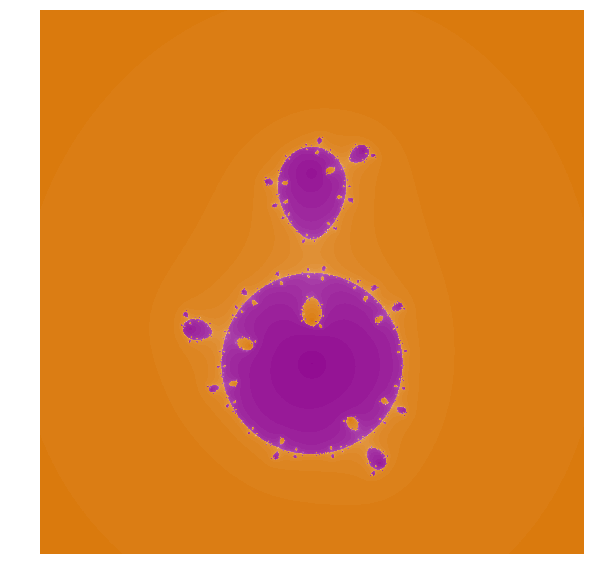

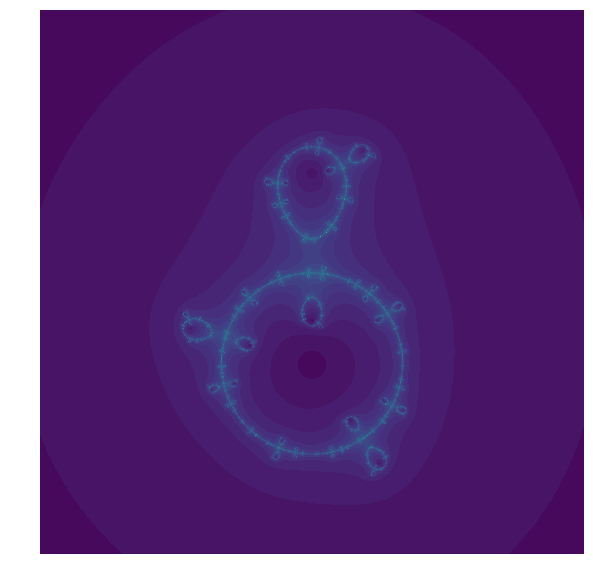

In [10]:
colors = np.array([[0.85,0.45,0], [0.55,0,0.55], [0,0.55,0.55], [0.7,0.15,0.1], [0.36,0.7,0.28], [0.8,0.75,0.18], [0.,0.33,0.64]])
colors_mixed = np.array([[0,0.5,0.5], [0.85,0.45,0], [0.5,0,0.5], [0.7,0,0], [0,0.7,0], [0,0,0.5]])
degree = 2
c=-0.32900228847128386065 + 1.28836653057612472969j

resolution = 2**11
angle = np.pi/4
name = 'blask4_md.png'
side_len = 6
off_hor = -3
off_ver = -2.1
xlims = [off_hor, side_len+off_hor]
ylims = [off_ver, side_len+off_ver]
#xlims, ylims = [-8, 4], [-4,4]
gscale, rts = get_matrix(blask, res=resolution, xlims=xlims, ylims=ylims)#107.546 pixels/sec (3r), 83886 (5e)

img = coloured_newton(gscale, rts, colors = colors)#169.500 pixels/sec
io.imsave(name, img)
plt.figure(figsize = (10, 10))
plt.axis('off')
plt.imshow(img)
plt.show()
plt.figure(figsize = (10, 10))
plt.axis('off')
plt.imshow(gscale)
plt.show()

In [17]:

print(np.max(gscale))

39.0


In [23]:
angle = (1./(2*np.pi))
c = (2*np.exp(2*np.pi*angle*1j) - np.exp(4*np.pi*angle*1j))/4

def func(z):
    return z**2 +c


(0.6369521805920959+0.13905648713168536j) (0.9948470486511263+0.21682438996215764j) (0.6018719060549389+0.1309217609880301j) (0.9895931291509514+0.21560665784805294j)


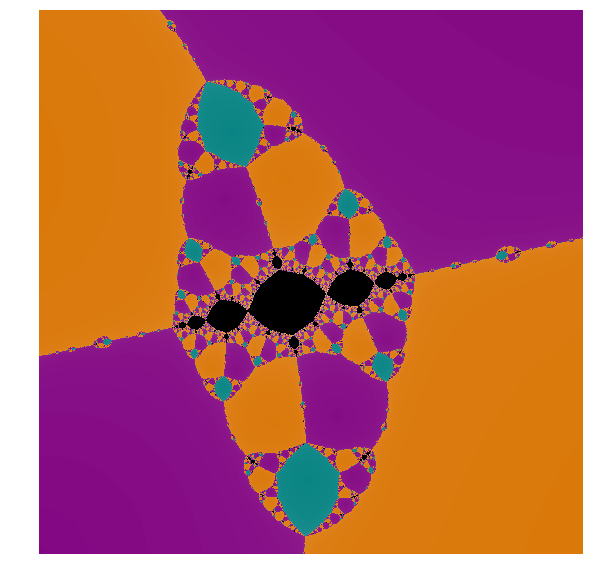

In [20]:
#load pic to repaint
name = 'cubic_newton'
img1 = io.imread(name+'.png')

points = []

init_point = 0.637+0.139j

points += iterations(init_point, newton, 10000)
print(points[-1], points[-2], points[-3], points[-4])



side_len = 3
off_hor = -1.5
off_ver = -1.5
xlims = [off_hor, side_len+off_hor]
ylims = [off_ver, side_len+off_ver]
xlims, ylims = [0.5, 0.8], [0,0.3]
repainted = paint_over_cross(img1, points, xlims, ylims, color=[255,255,255], n=2)





io.imsave(name+'_repainted.png', repainted)
plt.figure(figsize = (10, 10))
plt.axis('off')
plt.imshow(repainted)
plt.show()